In [1]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from utils import tools
from modules.vae_base_module import VAEBaseModule
from models.vae_simple import SimpleVAE
from datasets.novelty_mnist import NoveltyMNISTDataModule

%matplotlib inline
plt.style.use('seaborn')

2021-04-19 12:22:23,944 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
default_path = os.path.join(os.getcwd(), '../configs/vae/vae_simple_mnist.yaml')
config = tools.load_config(default_path)

Experimental parameters
------
{'data-parameters': {'batch_size': 128,
                     'root_data_path': '/home/brahste/Datasets/NoveltyMNIST',
                     'train_fraction': 0.9},
 'experiment-parameters': {'datamodule': 'NoveltyMNISTDataModule',
                           'log_dir': 'logs',
                           'model': 'SimpleVAE',
                           'patience': None},
 'module-parameters': {'latent_dims': 10, 'learning_rate': None}}


In [3]:
datamodule = NoveltyMNISTDataModule(**config['data-parameters'])
datamodule.setup('test')

model = SimpleVAE(datamodule.data_shape, **config['module-parameters'])

module = VAEBaseModule(model, **config['module-parameters'])

checkpoint = torch.load('../logs/NoveltyMNISTDataModule/SimpleVAE/version_14/checkpoints/val_loss=0.00-epoch=40.ckpt')
module.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
test_novelty_scores = []
test_novelty_labels = []

module.model.eval()
with torch.no_grad():
    for batch_nb, batch_tuple in enumerate(datamodule.test_dataloader()):
        result = module.test_step(batch_tuple, batch_nb);
#         print(result['scores'].shape)
#         print(result['labels'].shape)
        test_novelty_scores.extend(result['scores'].numpy())
        test_novelty_labels.extend(result['labels'].numpy())
        
    # enumerate dataloader
    # write test step for module
    # return novelty scores


2021-04-19 12:22:32,185 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2021-04-19 12:22:32,186 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 4.05
2021-04-19 12:22:32,186 - DEBUG - findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,187 - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-19 12:22:32,187 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
2021-04-19 12:22:32,187 - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
2021-04-19 12:22:32,188 - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,188 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol

2021-04-19 12:22:32,215 - DEBUG - findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-19 12:22:32,215 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2021-04-19 12:22:32,216 - DEBUG - findfont: score(<Font 'Ubuntu' (Ubuntu-R.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,216 - DEBUG - findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 500 normal>) = 10.145
2021-04-19 12:22:32,216 - DEBUG - findfont: score(<Font 'Sarai' (Sarai.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,217 - DEBUG - findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
2021-04-19 12:22:32,217 - DEBUG - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,218 - DEBUG - findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 500 normal>) = 10.145
2021-04-19 12:22:32,219 - DEBUG

2021-04-19 12:22:32,244 - DEBUG - findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,244 - DEBUG - findfont: score(<Font 'KacstQurn' (KacstQurn.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,245 - DEBUG - findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal 800 normal>) = 10.43
2021-04-19 12:22:32,245 - DEBUG - findfont: score(<Font 'Lohit Malayalam' (Lohit-Malayalam.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,245 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 4.535
2021-04-19 12:22:32,245 - DEBUG - findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-04-19 12:22:32,246 - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,246 - DEBUG - findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
2021-04-19 

2021-04-19 12:22:32,279 - DEBUG - findfont: score(<Font 'Waree' (Waree.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,280 - DEBUG - findfont: score(<Font 'Bitstream Vera Serif' (VeraSeBd.ttf) normal normal 700 normal>) = 10.335
2021-04-19 12:22:32,280 - DEBUG - findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
2021-04-19 12:22:32,280 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBI.ttf) oblique normal 700 normal>) = 11.335
2021-04-19 12:22:32,281 - DEBUG - findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-04-19 12:22:32,281 - DEBUG - findfont: score(<Font 'AnjaliOldLipi' (AnjaliOldLipi.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,281 - DEBUG - findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-04-19 12:22:32,281 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) no

2021-04-19 12:22:32,312 - DEBUG - findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal 600 normal>) = 10.24
2021-04-19 12:22:32,312 - DEBUG - findfont: score(<Font 'Samyak Gujarati' (Samyak-Gujarati.ttf) normal normal 500 normal>) = 10.145
2021-04-19 12:22:32,312 - DEBUG - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2021-04-19 12:22:32,313 - DEBUG - findfont: score(<Font 'Samanata' (samanata.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,313 - DEBUG - findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-RI.ttf) italic normal 400 normal>) = 11.05
2021-04-19 12:22:32,313 - DEBUG - findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-04-19 12:22:32,314 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2021-04-19 12:22:32,314 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 4

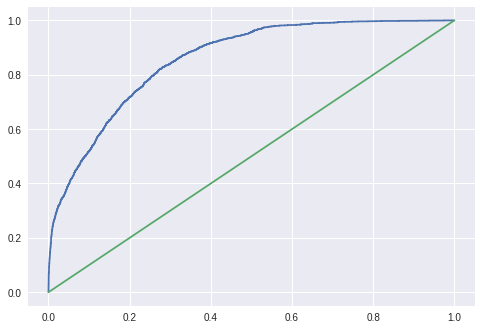

Model ROC AUC:  0.8566875791393699
Random ROC AUC:  0.5


In [5]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_novelty_labels, test_novelty_scores)
roc_auc_score = metrics.roc_auc_score(test_novelty_labels, test_novelty_scores)
roc_auc_score_rand = metrics.roc_auc_score([*[0.]*400, *[1.]*400], [0.5]*800)

plt.plot(fpr, tpr)
plt.plot([0., 1.], [0., 1.])
plt.show()
print('Model ROC AUC: ', roc_auc_score)
print('Random ROC AUC: ', roc_auc_score_rand)